This is a short notebook to investigate the std dev of the jitter in SMAP locations

The SMAP L1C files for each orbit are resampled onto the typical RSS grid, but there is jitter for the exact locations around the target locations because the closest resampled footprint is chosen.  The jitter in lat and lon unit depend on the latitude.

In [2]:
# resample_SMAP_to_grid_circular_footprint.py
import numpy as np
import xarray as xr
from pathlib import Path 
import datetime
from read_SMAP import find_SMAP_L1C_filenames_for_orbit,read_SMAP_L1C_file
import matplotlib.pyplot as plt
from rss_gridding.local_earth_grid import LocalEarthGrid
from rss_plotting.global_map import plot_global_map

Here we load in one day of SMAP L1C file, and find the stddev between the reported locations and the target locations.  The data are averaged along the longitude and look axes, and reported as a function of latitude.  The results for each file are plotted.

\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27590_20200401T005305_2020092_FNL_V05.0.nc


c:\Users\Carl\miniconda3\envs\rss-analysis310\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27591_20200401T023134_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27592_20200401T041000_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27593_20200401T054830_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27594_20200401T072655_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27595_20200401T090525_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27596_20200401T104350_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27597_20200401T122220_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27598_20200401T140046_2020092_FNL_V05.0.nc
\\athena\public\ftp\smap\SSS\V05.0\FINAL\L2C\2020\04\RSS_SMAP_SSS_L2C_r27599_20200401T15

Text(0, 0.5, 'Standard Deviation of Lat/Lon Jitter (deg)')

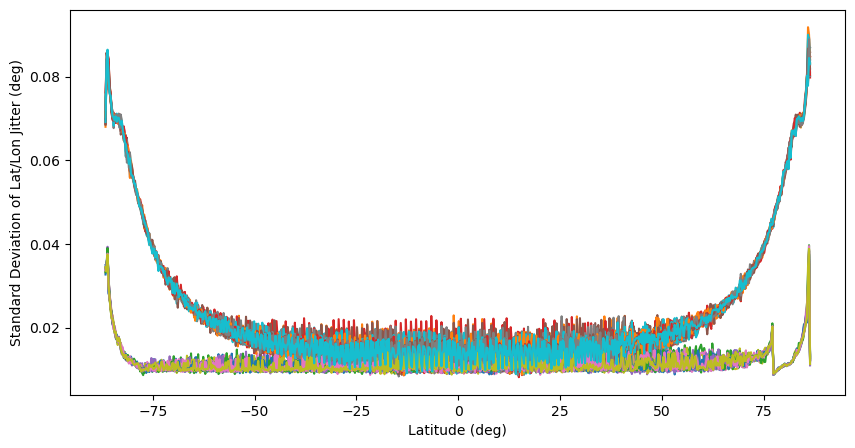

In [3]:
date = datetime.date(2020, 4, 1)
files = find_SMAP_L1C_filenames_for_orbit(date=date)
num_files = len(files)
stdlat_by_lat_array = np.zeros((num_files, 720))
stdlon_by_lat_array = np.zeros((num_files, 720))

fig,ax = plt.subplots(1,1,figsize=(10,5))

lats = -90.0 + 0.125 + 0.25*np.arange(720)
for ifile,smap_file in enumerate(files):
    smap_xr = read_SMAP_L1C_file(path=smap_file)
    print(smap_file)

    smap_lons = smap_xr['cellon'].values
    smap_lats = smap_xr['cellat'].values
    
    smap_lats_ideal = np.round(4.0*(smap_lats+0.125))/4.0 -0.125
    lat_diff = smap_lats_ideal - smap_lats

    smap_lons_ideal = np.round(4.0*(smap_lons+0.125))/4.0 - 0.125
    lon_diff = smap_lons_ideal - smap_lons

    lat_diff = np.reshape(lat_diff,(720,2*1560))
    lon_diff = np.reshape(lon_diff,(720,2*1560))

    stdlat_diff_by_lat = np.nanstd(lat_diff,axis=1)
    stdlon_diff_by_lat = np.nanstd(lon_diff,axis=1)

    ax.plot(lats,stdlat_diff_by_lat)
    ax.plot(lats,stdlon_diff_by_lat)

    stdlat_by_lat_array[ifile,:] = stdlat_diff_by_lat
    stdlon_by_lat_array[ifile,:] = stdlon_diff_by_lat

ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('Standard Deviation of Lat/Lon Jitter (deg)')




The plot above suggests that there is not much variation from orbit to orbit, so it is OK to average the results together.  The latitude std dev's are fairly constant.  The longitude std dev's increase at high latitude as expected.

C:\Users\Carl\AppData\Local\Temp\ipykernel_11236\3513875134.py:1: RuntimeWarning: Mean of empty slice
  mean_stdlat_diff_by_lat = np.nanmean(stdlat_by_lat_array,axis=0)
C:\Users\Carl\AppData\Local\Temp\ipykernel_11236\3513875134.py:2: RuntimeWarning: Mean of empty slice
  mean_stdlon_diff_by_lat = np.nanmean(stdlon_by_lat_array,axis=0)


Text(0.15, 0.9, 'Std. Dev. Longitude Jitter = 0.013*sec(lat)^-0.8')

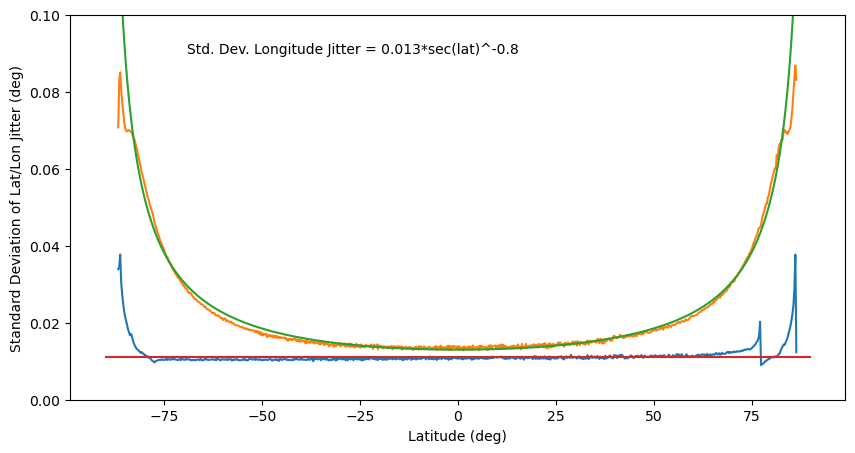

In [5]:
mean_stdlat_diff_by_lat = np.nanmean(stdlat_by_lat_array,axis=0)    
mean_stdlon_diff_by_lat = np.nanmean(stdlon_by_lat_array,axis=0)

fig2,ax2 = plt.subplots(1,1,figsize=(10,5))
ax2.plot(lats,mean_stdlat_diff_by_lat)
ax2.plot(lats,mean_stdlon_diff_by_lat)

std_lon_fit = 0.013/(np.cos(np.deg2rad(lats))**0.8)
ax2.plot(lats,std_lon_fit)
ax2.set_ylim([0,0.1])

std_lat_fit = np.full_like(lats,0.011)
ax2.plot(lats,std_lat_fit)
ax2.set_xlabel('Latitude (deg)')
ax2.set_ylabel('Standard Deviation of Lat/Lon Jitter (deg)')
ax2.text(0.15,0.9,'Std. Dev. Longitude Jitter = 0.013*sec(lat)^-0.8',transform=ax2.transAxes)

The latitude std is constant near 0.011 degrees for most latitudes.  The longitude stddev increases at high latitude as the longitudes get closer together in x/y space.  One might expect that the std dev ~ secant(latitude), but a better fit is found if we use Secant(latitude)^0.8 (which is weird).

For estimating footprint distortion in resample_wts\SMAP\compare_SMAP_tbs_target_resampled_across_swath.py, I'll use the following:
Std. Dev. Latitude  = 0.011 degrees
Std. Dev. Longitude = 0.013*secant(latitude)^0.8